## Deep learning

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import data_processing
import feature_extraction

Load Data

In [2]:
feature_df = pd.read_csv("mode_classification_features.csv")
X = feature_df.drop(columns=['trajectory', 'label'])  # Drop irrelevant columns and the target.
Y = feature_df['label']  # Target variable

One-hot-transform

In [3]:
y_one_hot = pd.get_dummies(Y)
y_one_hot

,bike,bus,car,subway,taxi,train,walk
0,False,False,False,False,False,True,False
1,False,False,False,False,True,False,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...
3637,True,False,False,False,False,False,False
3638,False,False,False,False,False,False,True
3639,False,False,False,False,False,False,True
3640,False,False,False,False,False,False,True


Train/Test Split

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

Initialize the Model

In [ ]:
def create_model(activation='relu', optimizer='adam', dropout_rate=0.3, neurons=128):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(neurons / 2), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Create the model

In [6]:
model = create_model()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train the model

In [7]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=1)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4549 - loss: 1.5479 - val_accuracy: 0.6557 - val_loss: 1.1270
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6914 - loss: 1.0515 - val_accuracy: 0.6790 - val_loss: 0.9814
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6975 - loss: 0.9253 - val_accuracy: 0.7023 - val_loss: 0.8855
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7225 - loss: 0.8423 - val_accuracy: 0.7311 - val_loss: 0.8343
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.7316 - loss: 0.8177 - val_accuracy: 0.7449 - val_loss: 0.8168
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.7376 - loss: 0.7986 - val_accuracy: 0.7586 - val_loss: 0.7713
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7680 - loss: 0.6957 - val_accuracy: 0.7654 - val_loss: 0.7465
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7772 - loss: 0.7034 - val_accuracy: 0.7668 - val

Evaluate on the test set

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8066 - loss: 0.5778
Test Loss: 0.5731992721557617
Test Accuracy: 0.8257887363433838


Plot

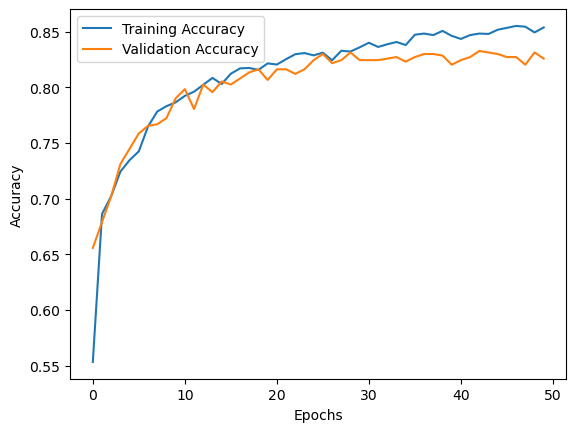

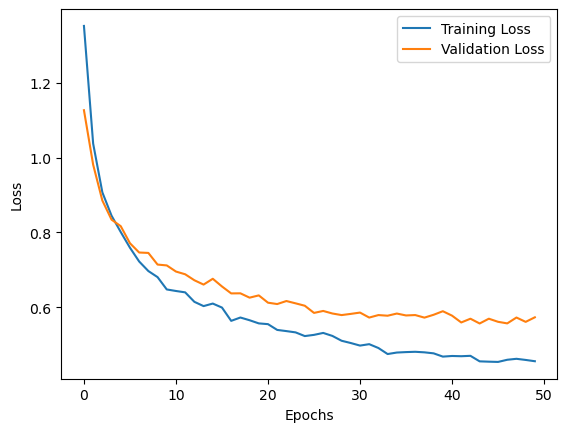

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation

In [19]:
model = KerasClassifier(model=create_model, verbose=0, activation='relu', dropout_rate=0.2, neurons=128, optimizer='adam')

Define hyperparameter grid

In [23]:
param_grid_dl = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'neurons': [64, 128, 256],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

Grid Search with 3-fold cross-validation

In [27]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_dl, cv=3, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Best Parameters: {'activation': 'relu', 'batch_size': 16, 'dropout_rate': 0.4, 'epochs': 100, 'neurons': 256, 'optimizer': 'adam'}


#Überlegen: Stratified CV

In [31]:
# Retrieve the best model
best_model = grid_result.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optionally: Display the confusion matrix
y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_int, y_pred_int)
print("Confusion Matrix:\n", cm)

Test Accuracy: 0.8477366255144033
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86       154
           1       0.81      0.66      0.73       101
           2       0.85      0.85      0.85        96
           3       0.83      0.71      0.77        35
           4       0.50      0.37      0.43        27
           5       0.50      0.33      0.40         3
           6       0.88      0.96      0.91       313

   micro avg       0.85      0.85      0.85       729
   macro avg       0.75      0.68      0.71       729
weighted avg       0.84      0.85      0.84       729
 samples avg       0.85      0.85      0.85       729

Confusion Matrix:
 [[134   2   1   0   0   0  17]
 [ 11  67   4   3   3   1  12]
 [  0   6  82   1   4   0   3]
 [  0   0   1  25   3   0   6]
 [  3   4   5   1  10   0   4]
 [  0   1   1   0   0   1   0]
 [  8   3   3   0   0   0 299]]


Extract the best model parameters

In [32]:
best_params = grid_result.best_params_
best_model = create_model(
    activation=best_params['activation'],
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    neurons=best_params['neurons']
)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2, 
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4912 - loss: 1.4292 - val_accuracy: 0.7204 - val_loss: 0.9770
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7009 - loss: 0.8998 - val_accuracy: 0.7513 - val_loss: 0.8545
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7316 - loss: 0.8195 - val_accuracy: 0.7736 - val_loss: 0.7904
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7418 - loss: 0.7415 - val_accuracy: 0.7856 - val_loss: 0.7740
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7730 - loss: 0.6720 - val_accuracy: 0.8010 - val_loss: 0.7081
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7785 - loss: 0.6389 - val_accuracy: 0.8010 - val_loss: 0.7117
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8119 - loss: 0.5837 - val_accuracy: 0.8182 - val_loss: 0.7012
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8081 - loss: 0.6062 - val_accuracy: 0.8233

Plot

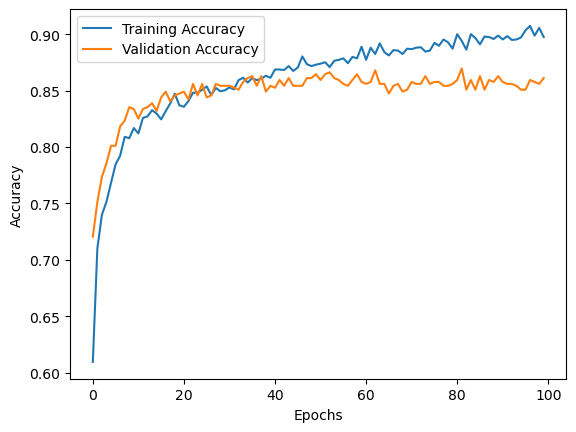

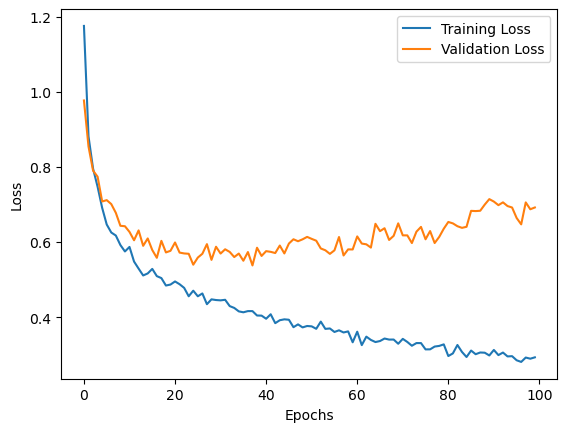

In [33]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()